# 📊 Week 1 — Exploratory Data Analysis (EDA): Reading Guide

**Learning Objectives (Week 1 – EDA)**  
- Understand the motivation for MLOps and how EDA fits into a production ML lifecycle.  
- Connect to Redshift and perform reproducible EDA.  
- Document data quality issues and define target/feature schema.  
- Prepare train/validation/test splits with leakage-aware methodology.  

> **Context**: ZAP is targeting **MLOps Level 2**. Even EDA should be reproducible and versioned (data query, sampling, and preprocessing code committed).

## 🔍 What is EDA and Why It Matters
Exploratory Data Analysis (EDA) is the process of **exploring, visualizing, and validating datasets** before training models.  
In **MLOps**, EDA is about much more than plots — it’s about **data reliability** and ensuring downstream pipelines are stable.

**Why it matters for production:**
- 🗑️ **Garbage in, garbage out** → poor data = poor models.  
- ⚡ **Operational resilience** → detect defects early, before they hit production.  
- 🔁 **Pipeline reliability** → schemas and checks from EDA become the foundation for automation.  


## 📐 Data Quality Dimensions
Checking data quality ensures your model won’t collapse when facing real-world inputs. Here are the key dimensions:

| Dimension    | Question to Ask | Example Issue |
|--------------|-----------------|---------------|
| ✅ Completeness | Are required values present? | Missing customer age |
| 🔄 Consistency | Do values follow expected formats/relations? | Country code "PT" inconsistently mapped |
| 🎯 Accuracy | Are values correct? | Negative product price |
| 🧩 Validity | Do values conform to rules/types? | Dates stored as free-text |
| ⏱️ Timeliness | Is the data up to date? | Using last year’s sales for today’s forecast |


## ⚠️ Leakage and Target Contamination
- **Data leakage** → using information not available at prediction time.  
- **Target contamination** → when the target leaks into features or data splits.  

❌ Example leakage: Using "credit approval status" as a feature to predict loan approval.  
❌ Example contamination: Randomly splitting time-series data, letting future events “leak” into training.

➡️ Both lead to inflated metrics **during training** and catastrophic failures **in production**.


## ♻️ Reproducibility
Reproducibility = **same results given same inputs**. Essential for trust, debugging, and collaboration.

Key practices:
- 🎲 **Fixed seeds** → ensure reproducible sampling/splitting.  
- 📑 **Deterministic queries** → e.g., always `ORDER BY id` in SQL.  
- 🖥️ **Environment capture** → record Python & library versions, OS, hardware.  

Without reproducibility → experiments can’t be compared, bugs can’t be traced.


## 📦 Outputs That Feed the Pipeline
EDA is not a one-off. Its **outputs become artifacts** for the ML pipeline:

- 🗂️ **Feature schema** → defines types, ranges, categories, nullability.  
- ✅ **Data checks** → rules like “no nulls in IDs” or “target is binary.”  
- ✂️ **Split strategy** → deterministic, leakage-free train/val/test partitions.  

These artifacts support:
- Automation in CI/CD ✅  
- Monitoring in production 📈  
- MLOps Level 2 maturity ⚙️  

---

# 📝 Exercises - Build the Dataset

You should choose any dataset existing on Redshift to practice EDA, and gather relevant information to train your model.  
Dataset example should contain customer demographics, services, account info, etc.

## Import needed libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

w = 800

## 🔧 Setup
Use the function `load_data()` provided in file `data_io.py` snippet to create a dataset from `parquet` on S3 bucket or directly from `redshift`

In [2]:
df = pd.read_parquet('../sample_data_from_redshift/sample.parquet')

dates = ['iddim_date_inicio', 'iddim_date_fim']

for col in df.columns:
    if col in dates:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    else:
        df[col] = pd.to_numeric(df[col], errors='ignore')

/var/folders/3d/dh5fxyvd55sbf5r8pv3bfclw0000gq/T/ipykernel_19126/2436523170.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
/var/folders/3d/dh5fxyvd55sbf5r8pv3bfclw0000gq/T/ipykernel_19126/2436523170.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


## 1. Data Overview & Metadata
Inspect the dataset:
- Number of rows and columns.  
- Data types of each column.  
- Identify categorical, numerical, and target.  

In [3]:
# number of rows and columns

print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 100000
Number of columns: 58


In [4]:
display(pd.DataFrame(df.dtypes))

,0
idconsumo,int32
id_contaservico,int32
codigocontaservico,int64
idconta,int32
iddim_date_inicio,datetime64[us]
iddim_date_fim,datetime64[us]
id_produto_actual,int32
tipo_produto_actual,object
tipo_subscricao,int16
tipo_stb,object


## 2. Data Quality Checks
After identifying the tables you want to work on, a crucial step is to analyze their Data Quality using the following dimensions.
Check the **5 quality dimensions** on this dataset:

| Dimension    | Task |
|--------------|------|
| ✅ Completeness | Count missing/null values in each column. |
| 🔄 Consistency | Look for inconsistent categories (e.g., “Male” vs. “male”). |
| 🎯 Accuracy | Spot anomalies (e.g., negative charges). |
| 🧩 Validity | Ensure logics are met. Ex: `TotalProfit ≈ n_units × unitary_profit`. |
| ⏱️ Timeliness | Discuss whether tenure captures freshness of data. |

In [5]:
display(df.isna().sum())

idconsumo                             0
id_contaservico                       0
codigocontaservico                    0
idconta                               0
iddim_date_inicio                     0
iddim_date_fim                        0
id_produto_actual                     0
tipo_produto_actual                   0
tipo_subscricao                       0
tipo_stb                             21
n_dias_subscricao                     0
n_dias_expirado                       0
contract_number                       0
contract_len_days                     0
tenure_days                           0
gap_since_prev_expiry              3751
mean_len_prev                      7229
std_len_prev                      10721
n_prev_contracts                      0
expiry_month                          0
expiry_dow                            0
tenure_bucket                         0
churn                                 0
past_churns                           0
iddim_cliente                        80


## 3. Target Variable Exploration
- Plot the distribution of target table.  
- Discuss if the dataset is **imbalanced** and what that implies for modeling.

In [6]:
print('Churn Value Counts:')
print(df['churn'].value_counts())

print('Churn Value Counts (percentage):')
print(df['churn'].value_counts(normalize = True))

vc = pd.DataFrame(df['churn'].value_counts()).reset_index()
fig = px.bar(vc, x = 'churn', y = 'count', title = 'Churn Value Counts', width = w, height = w/1.5)
fig.show()

Churn Value Counts:
churn
0    70329
1    29671
Name: count, dtype: int64
Churn Value Counts (percentage):
churn
0    0.70329
1    0.29671
Name: proportion, dtype: float64


## 4. Univariate Analysis
- For numerical columns:  
  - Plot histograms & boxplots.  
  - Identify outliers and skewed distributions.  

- For categorical columns:  
  - Plot bar charts of category counts.  
  - Check if categories have enough representation.

In [7]:
# Function to plot histograms for numeric columns and bar plots for categorical columns
def plot_columns(df):
    df = df.copy()

    cols_with_id = [col for col in df.columns if 'id' in col.lower() or 'codigo' in col.lower()]
    df = df.drop(columns=cols_with_id)

    for col in df.columns:
        # Try to convert to numeric
        df[col] = pd.to_numeric(df[col], errors='ignore')

        if pd.api.types.is_numeric_dtype(df[col]):
            # Histogram for numeric columns
            fig = px.histogram(df, x=col, title=f"Histogram — {col}", width=w, height=w/1.5, marginal = 'box')
        else:
            # Bar plot for categorical columns (top 20)
            counts = df[col].value_counts().head(20).reset_index()
            counts.columns = [col, 'count']
            fig = px.bar(counts, x=col, y='count', text='count', title=f"Bar Plot — {col}", width=w, height=w/1.5)
            fig.show()

In [8]:
#plot_columns(df)

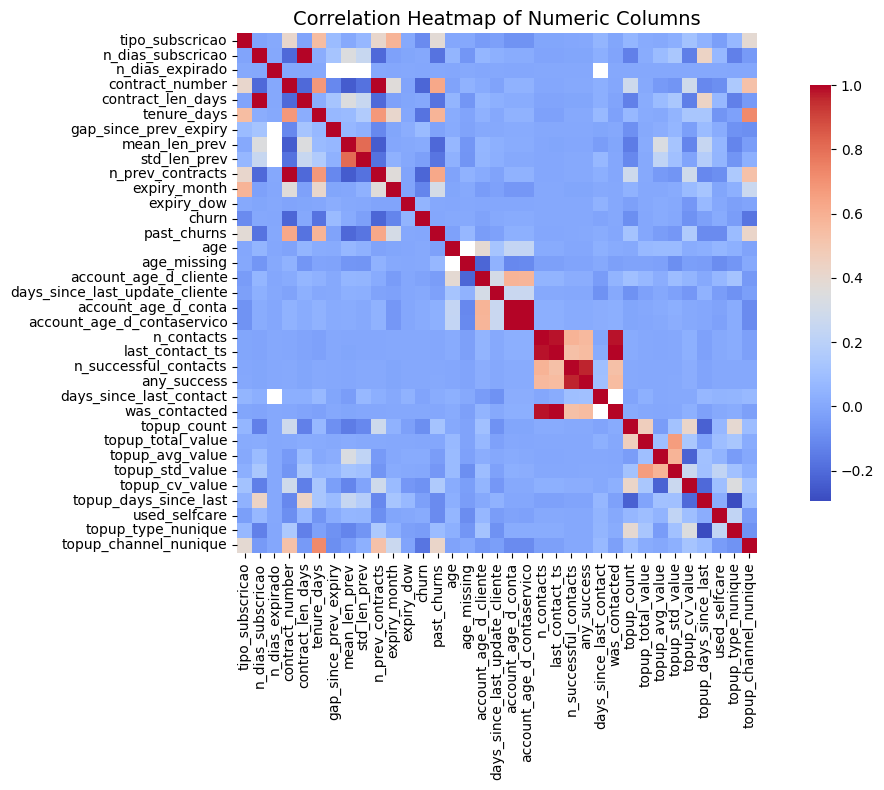

In [12]:
# Correlation matrix

cols_with_id = [col for col in df.columns if 'id' in col.lower() or 'codigo' in col.lower()]
pl = df.drop(columns=cols_with_id)

# Compute correlation only on numeric columns
corr = pl.select_dtypes(include='number').corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(
    corr,
    annot=False,          # Show correlation values
    fmt=".2f",           # Format to 2 decimals
    cmap="coolwarm",     # Color palette
    square=True,         # Keep cells square
    cbar_kws={"shrink": .8}  # Adjust colorbar size
)

plt.title("Correlation Heatmap of Numeric Columns", fontsize=14)
plt.tight_layout()
plt.show()

## 5. Bivariate Analysis
- Compare target column across categorical columns :  

- Compare target column across numerical features:  
  - Ex: How does the values of a column grow proportinally and disproportionally in relation with another; Compare average column values for different target column values. 

In [ ]:
def bivariate_analysis(df, wrap=4, top_k=10, sample=None):
    """
    Bivariate analysis vs 'churn':
      - Categorical features → normalized stacked bar plots
      - Numerical features → box plots grouped by churn
      - Numerical summary → heatmap of mean values per churn
    """
    d = df.copy()
    target = 'churn'

    cols_with_id = [col for col in d.columns if 'id' in col.lower() or 'codigo' in col.lower()]
    d = d.drop(columns=cols_with_id)

    # Optional sampling
    if sample is not None and len(d) > sample:
        d = d.sample(sample, random_state=42)

    # Detect column types
    num_cols = d.select_dtypes(include='number').columns.tolist()
    cat_cols = [c for c in d.columns if c not in num_cols and c != target]

    # Ensure churn is categorical
    d[target] = d[target].astype(str)

    # === 1. CATEGORICAL FEATURES vs CHURN ===
    if cat_cols:
        melted = d[cat_cols + [target]].melt(
            id_vars=target, var_name='column', value_name='category'
        )
        melted['category'] = melted['category'].astype(str).fillna('<NA>')

        # Keep top-K categories per column
        parts = []
        for c in cat_cols:
            vc = melted.loc[melted['column'] == c, 'category'].value_counts()
            keep = vc.head(top_k).index
            tmp = melted[melted['column'] == c].copy()
            tmp.loc[~tmp['category'].isin(keep), 'category'] = f'__other__ (>{top_k})'
            parts.append(tmp)
        melted = pd.concat(parts)

        counts = (
            melted.groupby(['column', 'category', target], as_index=False)
            .size()
            .rename(columns={'size': 'count'})
        )
        counts['pct'] = (
            counts.groupby(['column', 'category'])['count']
            .apply(lambda x: x / x.sum())
            .values
        )

        fig_cat = px.bar(
            counts, x='category', y='pct', color=target,
            facet_col='column', facet_col_wrap=wrap,
            barmode='stack', title='Churn share within each category',
            hover_data={'count': True, 'pct': ':.1%'}
        )
        fig_cat.update_yaxes(tickformat=".0%", matches=None)
        fig_cat.update_xaxes(matches=None, tickangle=45)
        fig_cat.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
        rows = (len(cat_cols) - 1) // wrap + 1
        fig_cat.update_layout(height=320 * rows, margin=dict(t=40))
        fig_cat.show()

# === 2. NUMERICAL FEATURES vs CHURN (BOX PLOTS with auto y-range) ===
    num_cols = [c for c in num_cols if c != target]
    if num_cols:
        long_num = d[num_cols + [target]].melt(
            id_vars=target, var_name='column', value_name='value'
        ).dropna(subset=['value'])

        fig_box = px.box(
            long_num, x=target, y='value', color=target,
            facet_col='column', facet_col_wrap=wrap,
            title='Numerical features by churn — box plots'
        )

        # ✅ Each box plot keeps its own Y range
        fig_box.update_yaxes(matches=None)
        fig_box.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
        rows = (len(num_cols) - 1) // wrap + 1
        fig_box.update_layout(height=300 * rows, margin=dict(t=40))
        fig_box.show()

        # === 3. MEAN VALUES per CHURN ===
        means = d.groupby(target, dropna=False)[num_cols].mean(numeric_only=True).T
        fig_heat = px.imshow(
            means, labels=dict(x='Churn', y='Feature', color='Mean'),
            title='Average numerical feature values per churn value'
        )
        fig_heat.update_layout(margin=dict(t=40))
        fig_heat.show()

In [ ]:
#bivariate_analysis(df, wrap=4, top_k=10, sample=None)

In [19]:
# Point biserial and Cramers correlation

from scipy.stats import chi2_contingency, pointbiserialr

def cramers_v(x, y):
    """Cramér’s V for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

def is_numeric_dtype(series):
    """Helper to safely detect numeric dtypes including pandas nullable ones."""
    return pd.api.types.is_numeric_dtype(series)

def corr_with_churn(df, target='churn', max_cat_unique=20):
    """Compute correlation of all columns with binary target."""
    results = []

    for col in df.columns:
        if col == target:
            continue

        # Skip all-null or constant columns
        if df[col].nunique(dropna=True) <= 1:
            continue

        try:
            if is_numeric_dtype(df[col]):
                # Numeric feature → point-biserial correlation
                corr, _ = pointbiserialr(df[col].astype(float), df[target])
                method = 'point-biserial'
            elif df[col].dtype == 'object' or df[col].nunique() <= max_cat_unique:
                # Categorical feature → Cramér’s V
                corr = cramers_v(df[col].astype(str), df[target])
                method = 'cramers_v'
            else:
                continue  # skip high-cardinality non-numeric columns

            results.append({'feature': col, 'correlation': corr, 'method': method})

        except Exception as e:
            print(f"Skipping {col}: {e}")

    corr_df = pd.DataFrame(results)
    return corr_df.sort_values('correlation', ascending=False).reset_index(drop=True)

In [18]:
corr_df = corr_with_churn(df, target='churn')
print(corr_df.head(20))

                  feature  correlation          method
0           tenure_bucket     0.154783       cramers_v
1     tipo_produto_actual     0.105954       cramers_v
2               municipio     0.072645       cramers_v
3       id_produto_actual     0.058053  point-biserial
4               provincia     0.055460       cramers_v
5              expiry_dow     0.045518  point-biserial
6                tipo_stb     0.027372       cramers_v
7      codigocontaservico     0.017507  point-biserial
8                    sexo     0.012188       cramers_v
9           used_selfcare     0.011474  point-biserial
10           estado_civil     0.008986       cramers_v
11              tipoconta     0.007442       cramers_v
12             tecnologia     0.004397       cramers_v
13  n_successful_contacts     0.001579  point-biserial
14             n_contacts     0.001487  point-biserial
15          was_contacted     0.000544  point-biserial
16        last_contact_ts     0.000544  point-biserial
17      co

This table shows how strongly each feature is associated with your binary target churn (1 = churned, 0 = active), using the right correlation metric per type:
- Cramér’s V → for categorical vs binary features (strength only, 0–1)
- Point-biserial → for numeric vs binary features (direction ±, −1 to +1)

Values closer to 1 (or −1) imply a stronger relationship with churn.
Most of your values are below 0.15, meaning weak to moderate associations — typical for customer-churn datasets where multiple small factors combine.

## 7. Reproducibility Practices
- Set a **random seed** when sampling rows for inspection.  
- Save an **EDA profile report** .  
- Export a **feature schema JSON** with column names, types, and allowed ranges/categories.  

In [ ]:
# BAD: every run gives a different sample
df_sample = df.sample(500)

# GOOD: fixed seed = reproducible sampling
df_sample = df.sample(500, random_state=42)

In [20]:
# EDA profiler report

from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="EDA Report — Customer Churn", explorative=True)
profile.to_file("eda_report.html")

/Users/federicodealbawork/miniconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Summarize dataset:  92%|█████████▏| 58/63 [00:02<00:00, 19.76it/s, Describe variable: topup_channel_nunique]     


KeyboardInterrupt: 

In [21]:
# Feature schema json

import json

schema = {}

for col in df.columns:
    dtype = str(df[col].dtype)
    col_data = df[col].dropna()

    if pd.api.types.is_numeric_dtype(df[col]):
        schema[col] = {
            "type": dtype,
            "min": float(col_data.min()) if not col_data.empty else None,
            "max": float(col_data.max()) if not col_data.empty else None
        }

    elif pd.api.types.is_datetime64_any_dtype(df[col]):
        schema[col] = {
            "type": dtype,
            "min": str(col_data.min()) if not col_data.empty else None,
            "max": str(col_data.max()) if not col_data.empty else None
        }

    else:
        schema[col] = {
            "type": dtype,
            "categories": col_data.unique().tolist()
        }

with open("feature_schema.json", "w") as f:
    json.dump(schema, f, indent=2)

## 8. Train/Validation/Test Split Strategy
- Propose and implement a split strategy:  
  - Random stratified split by target column.  
  - Ensure reproducibility with a fixed random seed.  
  - Document why stratification is necessary here.  

In [ ]:
#Simplified version from prepare_data_for_training in sagemaker/training/training_utils.py

df = df.sort_values('iddim_date_inicio')

# Define cutoff points (e.g., last 20% for validation/test)
train_size = 0.8
val_size = 0.1  # 10% val, 10% test

n = len(df)
train_end = int(n * train_size)
val_end = int(n * (train_size + val_size))

df_train = df.iloc[:train_end]
df_val   = df.iloc[train_end:val_end]
df_test  = df.iloc[val_end:]

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

# Optional: check date ranges
print("Train until:", df_train['iddim_date_inicio'].max())
print("Val until:", df_val['iddim_date_inicio'].max())
print("Test until:", df_test['iddim_date_inicio'].max())

# 🎯 Deliverables
By the end of these exercises, you should have:
1. A **data dictionary**.  
2. Summary tables/plots of findings and key features.  
3. A **feature schema JSON** with data types and constraints.  
4. A **train/val/test split file** (e.g., `splits.json`) for reproducible downstream tasks.  

## Peer Validation
  - Reproducible data loading (query or seed).  
  - Clear schema with rationale per feature.  
  - Split method documented and leakage-safe.  
  - Artifacts present and versioned.

# 📊 Week 1 — Exploratory Data Analysis (EDA): Reading Guide

**Learning Objectives (Week 1 – EDA)**  
- Understand the motivation for MLOps and how EDA fits into a production ML lifecycle.  
- Connect to Redshift and perform reproducible EDA.  
- Document data quality issues and define target/feature schema.  
- Prepare train/validation/test splits with leakage-aware methodology.  

> **Context**: ZAP is targeting **MLOps Level 2**. Even EDA should be reproducible and versioned (data query, sampling, and preprocessing code committed).

## 🔍 What is EDA and Why It Matters
Exploratory Data Analysis (EDA) is the process of **exploring, visualizing, and validating datasets** before training models.  
In **MLOps**, EDA is about much more than plots — it’s about **data reliability** and ensuring downstream pipelines are stable.

**Why it matters for production:**
- 🗑️ **Garbage in, garbage out** → poor data = poor models.  
- ⚡ **Operational resilience** → detect defects early, before they hit production.  
- 🔁 **Pipeline reliability** → schemas and checks from EDA become the foundation for automation.  


## 📐 Data Quality Dimensions
Checking data quality ensures your model won’t collapse when facing real-world inputs. Here are the key dimensions:

| Dimension    | Question to Ask | Example Issue |
|--------------|-----------------|---------------|
| ✅ Completeness | Are required values present? | Missing customer age |
| 🔄 Consistency | Do values follow expected formats/relations? | Country code "PT" inconsistently mapped |
| 🎯 Accuracy | Are values correct? | Negative product price |
| 🧩 Validity | Do values conform to rules/types? | Dates stored as free-text |
| ⏱️ Timeliness | Is the data up to date? | Using last year’s sales for today’s forecast |


## ⚠️ Leakage and Target Contamination
- **Data leakage** → using information not available at prediction time.  
- **Target contamination** → when the target leaks into features or data splits.  

❌ Example leakage: Using "credit approval status" as a feature to predict loan approval.  
❌ Example contamination: Randomly splitting time-series data, letting future events “leak” into training.

➡️ Both lead to inflated metrics **during training** and catastrophic failures **in production**.


## ♻️ Reproducibility
Reproducibility = **same results given same inputs**. Essential for trust, debugging, and collaboration.

Key practices:
- 🎲 **Fixed seeds** → ensure reproducible sampling/splitting.  
- 📑 **Deterministic queries** → e.g., always `ORDER BY id` in SQL.  
- 🖥️ **Environment capture** → record Python & library versions, OS, hardware.  

Without reproducibility → experiments can’t be compared, bugs can’t be traced.


## 📦 Outputs That Feed the Pipeline
EDA is not a one-off. Its **outputs become artifacts** for the ML pipeline:

- 🗂️ **Feature schema** → defines types, ranges, categories, nullability.  
- ✅ **Data checks** → rules like “no nulls in IDs” or “target is binary.”  
- ✂️ **Split strategy** → deterministic, leakage-free train/val/test partitions.  

These artifacts support:
- Automation in CI/CD ✅  
- Monitoring in production 📈  
- MLOps Level 2 maturity ⚙️  

---

# 📝 Exercises - Build the Dataset

You should choose any dataset existing on Redshift to practice EDA, and gather relevant information to train your model.  
Dataset example should contain customer demographics, services, account info, etc.


## 🔧 Setup
Use the function `load_data()` provided in file `data_io.py` snippet to create a dataset from `parquet` on S3 bucket or directly from `redshift`

In [ ]:
#TODO

## 1. Data Overview & Metadata
Inspect the dataset:
- Number of rows and columns.  
- Data types of each column.  
- Identify categorical, numerical, and target.  

In [ ]:
#TODO

## 2. Data Quality Checks
After identifying the tables you want to work on, a crucial step is to analyze their Data Quality using the following dimensions.
Check the **5 quality dimensions** on this dataset:

| Dimension    | Task |
|--------------|------|
| ✅ Completeness | Count missing/null values in each column. |
| 🔄 Consistency | Look for inconsistent categories (e.g., “Male” vs. “male”). |
| 🎯 Accuracy | Spot anomalies (e.g., negative charges). |
| 🧩 Validity | Ensure logics are met. Ex: `TotalProfit ≈ n_units × unitary_profit`. |
| ⏱️ Timeliness | Discuss whether tenure captures freshness of data. |

In [ ]:
#TODO

## 3. Target Variable Exploration
- Plot the distribution of target table.  
- Discuss if the dataset is **imbalanced** and what that implies for modeling.

In [ ]:
#TODO

## 4. Univariate Analysis
- For numerical columns:  
  - Plot histograms & boxplots.  
  - Identify outliers and skewed distributions.  

- For categorical columns:  
  - Plot bar charts of category counts.  
  - Check if categories have enough representation.

In [ ]:
#TODO

## 5. Bivariate Analysis
- Compare target column across categorical columns :  

- Compare target column across numerical features:  
  - Ex: How does the values of a column grow proportinally and disproportionally in relation with another; Compare average column values for different target column values. 

In [ ]:
#TODO

## 7. Reproducibility Practices
- Set a **random seed** when sampling rows for inspection.  
- Save an **EDA profile report** .  
- Export a **feature schema JSON** with column names, types, and allowed ranges/categories.  

In [ ]:
#TODO

## 8. Train/Validation/Test Split Strategy
- Propose and implement a split strategy:  
  - Random stratified split by target column.  
  - Ensure reproducibility with a fixed random seed.  
  - Document why stratification is necessary here.  

In [ ]:
#TODO

# 🎯 Deliverables
By the end of these exercises, you should have:
1. A **data dictionary**.  
2. Summary tables/plots of findings and key features.  
3. A **feature schema JSON** with data types and constraints.  
4. A **train/val/test split file** (e.g., `splits.json`) for reproducible downstream tasks.  

## Peer Validation
  - Reproducible data loading (query or seed).  
  - Clear schema with rationale per feature.  
  - Split method documented and leakage-safe.  
  - Artifacts present and versioned.